In [1]:
import numpy as np
import pandas as pd
from typing import List
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import tqdm
import netCDF4 as nc
from sklearn.model_selection import train_test_split
from helpers import process_h as helper
from helpers import visualize_h as vis_helper

In [2]:
data_relative_path = os.path.join('..', 'Data')
precipitation_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
WTIO_path = os.path.join(data_relative_path,'CMIP6','WTIO')
SEIO_path = os.path.join(data_relative_path,'CMIP6','SEIO')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')
SLP_path = os.path.join(data_relative_path,'CMIP6','SLP')
GPH500_path = os.path.join(data_relative_path,'CMIP6', 'GPH500')
ERA5_path = os.path.join(data_relative_path, 'ERA5')

In [3]:
model_SAL_ranks = {
    "NorESM2-MM": 0.749380,
    "CanESM5-CanOE": 1.114961,
    "MIROC6": 1.214910,
    "FIO-ESM-2-0": 1.257748,
    "SAM0-UNICON": 1.260866,
    "E3SM-1-0": 1.302583,
    "IPSL-CM6A-LR": 1.320407,
    "CMCC-CM2-HR4": 1.532219,
    "HadGEM3-GC31-LL": 1.537500,
    "UKESM1-0-LL": 1.540298,
    "INM-CM5-0": 1.562396,
    "TaiESM1": 1.591490,
    "ACCESS-CM2": 1.595120,
    "MPI-ESM1-2-HR": 1.604126,
    "GFDL-ESM4": 1.690845,
    "NESM3": 1.696728,
    "IITM-ESM": 1.715063,
    "FGOALS-f3-L": 1.728859,
    "CAMS-CSM1-0": 1.791793,
    "EC-Earth3-AerChem": 1.810209,
    "MRI-ESM2-0": 1.863750,
    "MCM-UA-1-0": 1.875888,
    "CNRM-CM6-1-HR": 1.878019,
    "GISS-E2-1-H": 1.936683
}


## Data Loading

In [4]:
chirps_dataset = nc.Dataset(f"{CHIRPS_path}/CHIRPS_Monthly_precipitation.nc")
chirps_precip_data = ((chirps_dataset['precip'][:])[9::12, 280:360, 800:920])[:30, :, :]
gph500_baseline = np.squeeze((nc.Dataset(f"{ERA5_path}/GPH500_ERA5.nc"))['z'][:], axis=1)
mslp_baseline = (nc.Dataset(f"{ERA5_path}/MSLP_ERA5.nc"))['msl'][:]

In [5]:
# Converting units needed for converting models precipitation measurements
unit_conversion = 86400 * 31
# Map latitude and longitude boundaries
bounds_middle_east_lat = [20, 40]
bounds_middle_east_lon = [20, 50]
boundaries_middle_east = bounds_middle_east_lon + bounds_middle_east_lat
# A dimension we want our grid to have
dim = (16, 16)
chirps_dim = chirps_precip_data.shape[1], chirps_precip_data.shape[2]

In [6]:
options = {"interpolate": True,
           "force grid": False,
           "average": False}
options_avg = {"interpolate": True,
           "force grid": False,
           "average": True}

In [7]:
precip_for_corr = helper.collect_all_datasets(precipitation_path, 'precip', chirps_dim, unit_conversion, bounds_middle_east_lat, bounds_middle_east_lon, options)
precip = {key: val[0] for key, val in precip_for_corr.items()}
masked_precip = {key: np.ma.array(val, mask=chirps_precip_data.mask) for key, val in precip.items()}

  0%|                                                                                                   | 0/24 [00:00<?, ?it/s]

pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(30, 16, 16)


  4%|███▊                                                                                       | 1/24 [00:02<00:54,  2.36s/it]

pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
(30, 18, 27)


  8%|███████▌                                                                                   | 2/24 [00:03<00:40,  1.84s/it]

pr_Amon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
(30, 7, 10)


 12%|███████████▍                                                                               | 3/24 [00:04<00:29,  1.41s/it]

pr_Amon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
(30, 21, 25)


 17%|███████████████▏                                                                           | 4/24 [00:05<00:25,  1.27s/it]

pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19811016-20101016_v20191021.nc
(30, 40, 61)


 21%|██████████████████▉                                                                        | 5/24 [00:07<00:25,  1.35s/it]

pr_Amon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190913.nc
(30, 20, 30)


 25%|██████████████████████▊                                                                    | 6/24 [00:08<00:22,  1.26s/it]

pr_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19811016-20101016_v20200624.nc
(30, 28, 43)


 29%|██████████████████████████▌                                                                | 7/24 [00:09<00:20,  1.20s/it]

pr_Amon_FGOALS-f3-L_historical_r1i1p1f1_gr_19811016-20101016_v20190927.nc
(30, 20, 24)


 33%|██████████████████████████████▎                                                            | 8/24 [00:10<00:17,  1.11s/it]

pr_Amon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191209.nc
(30, 21, 25)


 38%|██████████████████████████████████▏                                                        | 9/24 [00:11<00:16,  1.07s/it]

pr_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19811016-20101016_v20190726.nc
(30, 20, 24)


 42%|█████████████████████████████████████▌                                                    | 10/24 [00:12<00:14,  1.02s/it]

pr_Amon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
(30, 10, 12)


 46%|█████████████████████████████████████████▎                                                | 11/24 [00:13<00:13,  1.00s/it]

pr_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
(30, 16, 16)


 50%|█████████████████████████████████████████████                                             | 12/24 [00:14<00:11,  1.02it/s]

pr_Amon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20191226.nc
(30, 10, 16)


 54%|████████████████████████████████████████████████▊                                         | 13/24 [00:15<00:10,  1.04it/s]

pr_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
(30, 14, 16)


 58%|████████████████████████████████████████████████████▌                                     | 14/24 [00:16<00:09,  1.04it/s]

pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19811016-20101016_v20180803.nc
(30, 16, 13)


 62%|████████████████████████████████████████████████████████▎                                 | 15/24 [00:17<00:08,  1.00it/s]

pr_Amon_MCM-UA-1-0_historical_r1i1p1f2_gn_19811017-20101017_v20191017.nc
(30, 9, 8)


 67%|████████████████████████████████████████████████████████████                              | 16/24 [00:17<00:07,  1.05it/s]

pr_Amon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc
(30, 15, 21)


 71%|███████████████████████████████████████████████████████████████▊                          | 17/24 [00:18<00:06,  1.05it/s]

pr_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
(30, 22, 32)


 75%|███████████████████████████████████████████████████████████████████▌                      | 18/24 [00:19<00:05,  1.03it/s]

pr_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_19811016-20101016_v20190222.nc
(30, 18, 27)


 79%|███████████████████████████████████████████████████████████████████████▎                  | 19/24 [00:20<00:04,  1.01it/s]

pr_Amon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190630.nc
(30, 10, 16)


 83%|███████████████████████████████████████████████████████████████████████████               | 20/24 [00:22<00:04,  1.05s/it]

pr_Amon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(30, 21, 25)


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 21/24 [00:23<00:03,  1.04s/it]

pr_Amon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc
(30, 21, 25)


 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 22/24 [00:24<00:02,  1.03s/it]

pr_Amon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200623.nc
(30, 21, 25)


 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 23/24 [00:25<00:01,  1.03s/it]

pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190406.nc
(30, 16, 16)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:26<00:00,  1.09s/it]


In [8]:
precip_avg = helper.collect_all_datasets(precipitation_path, 'precip', chirps_dim, unit_conversion, bounds_middle_east_lat, bounds_middle_east_lon, options_avg)
precip_avg= {key: val[0] for key, val in precip_avg.items()}

  8%|███████▌                                                                                   | 2/24 [00:00<00:01, 12.39it/s]

pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(16, 16)
pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
(18, 27)
pr_Amon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
(7, 10)


 17%|███████████████▏                                                                           | 4/24 [00:00<00:01, 13.33it/s]

pr_Amon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
(21, 25)
pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19811016-20101016_v20191021.nc
(40, 61)
pr_Amon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190913.nc
(20, 30)


 33%|██████████████████████████████▎                                                            | 8/24 [00:00<00:01, 12.54it/s]

pr_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19811016-20101016_v20200624.nc
(28, 43)
pr_Amon_FGOALS-f3-L_historical_r1i1p1f1_gr_19811016-20101016_v20190927.nc
(20, 24)
pr_Amon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191209.nc
(21, 25)


 50%|█████████████████████████████████████████████                                             | 12/24 [00:00<00:00, 12.90it/s]

pr_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19811016-20101016_v20190726.nc
(20, 24)
pr_Amon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
(10, 12)
pr_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
(16, 16)


 58%|████████████████████████████████████████████████████▌                                     | 14/24 [00:01<00:00, 11.87it/s]

pr_Amon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20191226.nc
(10, 16)
pr_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
(14, 16)
pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19811016-20101016_v20180803.nc


 67%|████████████████████████████████████████████████████████████                              | 16/24 [00:01<00:00, 12.30it/s]

(16, 13)
pr_Amon_MCM-UA-1-0_historical_r1i1p1f2_gn_19811017-20101017_v20191017.nc
(9, 8)
pr_Amon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc
(15, 21)


 83%|███████████████████████████████████████████████████████████████████████████               | 20/24 [00:01<00:00, 14.14it/s]

pr_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
(22, 32)
pr_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_19811016-20101016_v20190222.nc
(18, 27)
pr_Amon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190630.nc
(10, 16)
pr_Amon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(21, 25)


 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 22/24 [00:01<00:00, 14.31it/s]

pr_Amon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc
(21, 25)
pr_Amon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200623.nc
(21, 25)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.47it/s]

pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190406.nc
(16, 16)


In [9]:
dmi_baseline = scipy.io.loadmat(f"{data_relative_path}/DMI/DMI.mat")['DMI_Oct_1981_2022'][:, 1][:30]

In [10]:
wtio = helper.collect_all_datasets(WTIO_path, 'wtio')
seio = helper.collect_all_datasets(SEIO_path, 'seio')
dmi = helper.calc_dmi(wtio, seio, 'anomaly grid - mean first')

 12%|███████████▍                                                                               | 3/24 [00:00<00:00, 27.88it/s]

tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
tos_Omon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
tos_Omon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
tos_Omon_CNRM-CM6-1-HR_historical_r1i1p1f2_gn_19811016-20101016_v20191021.nc


 38%|██████████████████████████████████▏                                                        | 9/24 [00:00<00:00, 23.96it/s]

tos_Omon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190826.nc
tos_Omon_EC-Earth3-AerChem_historical_r1i1p1f1_gn_19811016-20101016_v20200624.nc
tos_Omon_FGOALS-f3-L_historical_r1i1p1f1_gn_19811016-20101016_v20191007.nc
tos_Omon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191122.nc
tos_Omon_GFDL-ESM4_historical_r1i1p1f1_gr_19811016-20101016_v20190726.nc
tos_Omon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc


 71%|███████████████████████████████████████████████████████████████▊                          | 17/24 [00:00<00:00, 27.77it/s]

tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
tos_Omon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20200915.nc
tos_Omon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
tos_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_19811016-20101016_v20180803.nc
tos_Omon_MCM-UA-1-0_historical_r0i0p0f2_gn_19811017-20101017_v20190731.nc
tos_Omon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc


 83%|███████████████████████████████████████████████████████████████████████████               | 20/24 [00:00<00:00, 25.01it/s]

tos_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
tos_Omon_MRI-ESM2-0_historical_r1i1p1f1_gr_19811016-20101016_v20190904.nc
tos_Omon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190703.nc
tos_Omon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc


100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.36it/s]


tos_Omon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200630.nc
tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190627.nc


  0%|                                                                                                   | 0/24 [00:00<?, ?it/s]

tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
tos_Omon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc


 17%|███████████████▏                                                                           | 4/24 [00:00<00:00, 23.04it/s]

tos_Omon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
tos_Omon_CNRM-CM6-1-HR_historical_r1i1p1f2_gn_19811016-20101016_v20191021.nc
tos_Omon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190826.nc


 29%|██████████████████████████▌                                                                | 7/24 [00:00<00:00, 25.29it/s]

tos_Omon_EC-Earth3-AerChem_historical_r1i1p1f1_gn_19811016-20101016_v20200624.nc
tos_Omon_FGOALS-f3-L_historical_r1i1p1f1_gn_19811016-20101016_v20191007.nc
tos_Omon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191122.nc
tos_Omon_GFDL-ESM4_historical_r1i1p1f1_gr_19811016-20101016_v20190726.nc


 46%|█████████████████████████████████████████▎                                                | 11/24 [00:00<00:00, 30.36it/s]

tos_Omon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
tos_Omon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20200915.nc
tos_Omon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc


 62%|████████████████████████████████████████████████████████▎                                 | 15/24 [00:00<00:00, 32.44it/s]

tos_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_19811016-20101016_v20180803.nc
tos_Omon_MCM-UA-1-0_historical_r0i0p0f2_gn_19811017-20101017_v20190731.nc
tos_Omon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc


 79%|███████████████████████████████████████████████████████████████████████▎                  | 19/24 [00:00<00:00, 29.16it/s]

tos_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
tos_Omon_MRI-ESM2-0_historical_r1i1p1f1_gr_19811016-20101016_v20190904.nc
tos_Omon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190703.nc
tos_Omon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc


100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 27.59it/s]


tos_Omon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200630.nc
tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190627.nc


  0%|                                                                                                   | 0/24 [00:00<?, ?it/s]/mnt/c/Users/user/Documents/University/Year_3/Final Project/sub-seasonal-cmip-analysis/src/helpers/process_h.py:262: RuntimeWarning: Mean of empty slice
  wtio_climatology = np.nanmean(wtio_model, axis=0)
/mnt/c/Users/user/Documents/University/Year_3/Final Project/sub-seasonal-cmip-analysis/src/helpers/process_h.py:263: RuntimeWarning: Mean of empty slice
  seio_climatology = np.nanmean(seio_model, axis=0)
100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 41.02it/s]


In [11]:
corrs = dict()
for key in tqdm.tqdm(masked_precip.keys()):
    corr_mat = helper.calc_dmi_precp_corr_vec(dmi[key], masked_precip[key])
    corrs[key] = corr_mat
corr_baseline = helper.calc_dmi_precp_corr_vec(dmi_baseline, chirps_precip_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.19it/s]


In [12]:
alpha = 0.05
tested_corrs = {key: np.where(helper.calc_corr_t_test(corr_map) > alpha, 0, corr_map) for key, corr_map in corrs.items()}
tested_corr_baseline = np.where(helper.calc_corr_t_test(corr_baseline) > alpha, 0, corr_baseline)

Create a X Design matrix when each row is a grid point and each feature is a model.

In [13]:
def get_precipitation_models() -> list[np.ndarray]:
    """
    Retrieves and processes precipitation models from a specified directory.
    Returns:
        list[np.ndarray]: A list of NumPy arrays where each array represents the mean
                          precipitation data computed across the first axis of the input arrays.
    """
    models: list[np.ndarray] = []
    for file in os.listdir(interpulated_cmip_path):
        model_path = os.path.join(interpulated_cmip_path, file)
        model_data = np.load(model_path)
        model_mean_data = np.mean(model_data, axis=0)
        models.append(model_mean_data)
    return models


## Data Preperations

In [14]:
def flatten_chirps(chirps_precip_data):
    chirps_2D = np.mean(chirps_precip_data,axis=0)
    flat_chirps_2D= chirps_2D.reshape(-1)
    return flat_chirps_2D

In [15]:
def flatten_models_to_grid_matrix(models) -> pd.DataFrame:
    """
    Create a design matrix X where each row represents a grid point, and each column 
    (feature) represents the flattened precipitation data from a different model.

    Parameters:
    -----------
    interpolated_precip_list : List[np.ndarray]
        A list of 2D arrays (matrices) with dimensions (400, 600) representing 
        precipitation data from different models. Each matrix corresponds to a different 
        model.

    Returns:
    --------
    np.ndarray
        A 2D array (design matrix X) of shape (240000, num_models), where:
        - Each row corresponds to a specific grid point across all models.
        - Each column corresponds to the precipitation data for that grid point from 
          a particular model.
    """


    # Initialize an empty matrix to store the reshaped data
    X = pd.DataFrame()

    # Loop over each model's matrix and reshape it into a vector
    for model, data_matrix in models.items():
        temp = pd.DataFrame(data_matrix.reshape(-1), columns=[model])
        X = pd.concat([X, temp], axis=1)
    return X


In [16]:
X_precip = flatten_models_to_grid_matrix(precip_avg)
y_precip = flatten_chirps(chirps_precip_data)
# Need to remove Null values from both, would require putting them in a df and then dropna on rows
precip_df = X_precip.copy()
precip_df["chirps"] = y_precip
precip_df = precip_df.dropna()
X_corr = flatten_models_to_grid_matrix(tested_corrs)
y_corr = tested_corr_baseline
# same, but asaf said we shouldn't bother with only correlations


In [17]:
precip_df

,ACCESS-CM2,CAMS-CSM1-0,CanESM5-CanOE,CMCC-CM2-HR4,CNRM-CM6-1-HR,E3SM-1-0,EC-Earth3-AerChem,FGOALS-f3-L,FIO-ESM-2-0,GFDL-ESM4,...,MCM-UA-1-0,MIROC6,MPI-ESM1-2-HR,MRI-ESM2-0,NESM3,NorESM2-MM,SAM0-UNICON,TaiESM1,UKESM1-0-LL,chirps
0,0.942319,0.479998,1.140655,0.660180,2.706106,1.176750,0.007037,0.451921,0.060178,0.568221,...,15.386412,1.196963,0.013848,1.112214,0.596841,0.018284,0.230899,0.031408,0.257650,0.000000e+00
1,1.030896,0.420120,1.120143,0.616831,2.168157,1.144615,0.007261,0.482080,0.056102,0.534466,...,15.109906,1.200772,0.033394,1.093325,0.594128,0.022368,0.201091,0.029774,0.284660,0.000000e+00
2,1.119473,0.360242,1.099632,0.573481,1.644705,1.112481,0.007485,0.512239,0.052027,0.500710,...,14.833400,1.204580,0.052939,1.074436,0.591416,0.026452,0.171283,0.028139,0.311670,4.302927e-05
3,1.208050,0.300364,1.079121,0.530132,1.976573,1.080346,0.008325,0.542398,0.047951,0.466955,...,14.556894,1.208389,0.072485,1.055546,0.588704,0.030535,0.141475,0.026505,0.338680,0.000000e+00
4,1.296627,0.240486,1.058609,0.486783,2.301950,1.048212,0.012241,0.572557,0.043876,0.433200,...,14.280388,1.212197,0.112312,1.036657,0.585991,0.034619,0.111667,0.024871,0.365691,1.074137e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9591,34.073127,58.971217,22.859548,62.468150,49.405016,27.745830,57.618589,40.718513,94.568915,84.763523,...,20.226058,74.458679,51.347647,30.310965,32.866714,22.337050,57.148507,106.691869,51.931830,3.552129e+01
9592,32.690535,58.798342,24.981958,60.452650,41.589271,26.405728,51.542294,37.577353,94.505708,84.693702,...,20.220303,74.330351,48.967447,27.634050,34.672814,22.718874,59.089874,105.792997,50.564148,4.604496e+01
9593,31.245781,58.625466,27.104367,58.437150,34.381061,25.065625,45.465999,34.436192,94.442500,84.623881,...,20.214548,74.202023,44.981415,24.957134,36.495647,23.100699,61.031241,104.894125,48.927082,5.373804e+01
9594,29.801028,58.452590,29.226776,56.421650,32.173967,23.725522,42.896721,31.566362,94.379292,83.928434,...,20.208792,71.513150,40.995382,22.280219,38.318480,23.482523,62.972607,103.995252,47.290017,5.516348e+01


# Split The Data randomly 

In [18]:
x_precipitation_train, x_precipitation_test, y_precipitation_train, y_precipitation_test =  train_test_split(precip_df.drop(['chirps'], axis=1), precip_df['chirps'], test_size=0.2, random_state=9)

# Trainig Linear Regression models 

In [19]:
results = {}

In [20]:
def adjusted_r2(X, y, y_pred):
    return 1 - (1-r2_score(y, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

#### Baseline - Mean of Y Train

In [21]:
most_basic_model = np.full_like(y_precipitation_test, np.mean(y_precipitation_train))

In [22]:
rmse_basic_test = root_mean_squared_error(y_precipitation_test, most_basic_model)
r2_basic_test = r2_score(y_precipitation_test, most_basic_model)
print(f"Baseline test RMSE: {rmse_basic_test}")
print(f"Baseline test R2: {r2_basic_test}")
results["Baseline - Mean of Y Train"] = [rmse_basic_test, r2_basic_test, 1]

Baseline test RMSE: 19.215734566031667
Baseline test R2: -0.0007369289878278451


#### Baseline - Mean of X

In [23]:
# baseline model
baseline_train_res = np.mean(x_precipitation_train, axis=1)
baseline_test_res = np.mean(x_precipitation_test, axis=1)

In [24]:
rmse_baseline_test = root_mean_squared_error(y_precipitation_test, baseline_test_res)
r2_baseline_test = adjusted_r2(x_precipitation_test, y_precipitation_test, baseline_test_res)
print(f"Baseline test RMSE: {rmse_baseline_test}")
print(f"Baseline test R2: {r2_baseline_test}")
results["Baseline - Mean of X"] = [rmse_baseline_test, r2_baseline_test, x_precipitation_test.shape[1]]

Baseline test RMSE: 8.111157503085456
Baseline test R2: 0.8189554886946508


#### Weighted Average by SAL Rank

In [25]:
weights = [rank for model, rank in model_SAL_ranks.items()]
weights = np.array(weights)
weights = weights / np.sum(weights)
weights

array([0.02015988, 0.02999477, 0.03268361, 0.03383604, 0.03391992,
       0.0350422 , 0.0355217 , 0.04121988, 0.04136195, 0.04143723,
       0.04203171, 0.0428144 , 0.04291205, 0.04315433, 0.04548725,
       0.04564552, 0.04613877, 0.04650991, 0.04820297, 0.0486984 ,
       0.05013876, 0.0504653 , 0.05052263, 0.05210081])

In [26]:
y_pred = np.average(x_precipitation_test, axis=1, weights=weights)
test_rmse = np.sqrt(mean_squared_error(y_precipitation_test, y_pred))
test_r2 = adjusted_r2(x_precipitation_test, y_precipitation_test, y_pred)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")
results["Weighted Average by SAL Rank"] = [test_rmse, test_r2, x_precipitation_test.shape[1]]

Test RMSE: 7.9611
Test R2: 0.8256


#### Naive Linear Regression

In [27]:
naive_lr_model_precipitation = LinearRegression()

naive_lr_model_precipitation.fit(x_precipitation_train, y_precipitation_train)

y_precipitation_pred_naive_lr = naive_lr_model_precipitation.predict(x_precipitation_test)

rmse_naive_lr_precipitation = root_mean_squared_error(y_precipitation_test, y_precipitation_pred_naive_lr)
r2_naive_lr_precipitation = adjusted_r2(x_precipitation_test, y_precipitation_test, y_precipitation_pred_naive_lr)

print(f"Naive Linear Regression Model - RMSE: {rmse_naive_lr_precipitation}, R2: {r2_naive_lr_precipitation}")

results["Linear Regression Model"] = [rmse_naive_lr_precipitation, r2_naive_lr_precipitation, x_precipitation_test.shape[1]]

Naive Linear Regression Model - RMSE: 4.330998765254457, R2: 0.9483826370372266


Our next steps would be to look at SAL and use it for feature selection.

In [28]:
sorted_features = sorted(model_SAL_ranks, key=model_SAL_ranks.get)
sorted_features

['NorESM2-MM',
 'CanESM5-CanOE',
 'MIROC6',
 'FIO-ESM-2-0',
 'SAM0-UNICON',
 'E3SM-1-0',
 'IPSL-CM6A-LR',
 'CMCC-CM2-HR4',
 'HadGEM3-GC31-LL',
 'UKESM1-0-LL',
 'INM-CM5-0',
 'TaiESM1',
 'ACCESS-CM2',
 'MPI-ESM1-2-HR',
 'GFDL-ESM4',
 'NESM3',
 'IITM-ESM',
 'FGOALS-f3-L',
 'CAMS-CSM1-0',
 'EC-Earth3-AerChem',
 'MRI-ESM2-0',
 'MCM-UA-1-0',
 'CNRM-CM6-1-HR',
 'GISS-E2-1-H']

In [29]:
def feature_selection(X, y, model, max_features=None, min_improvement=0.001):
    features = []
    rmse_scores = []
    r2_scores = []
    feature_importances = []

    if max_features is None:
        max_features = X.shape[1]
    
    previous_best_rmse = float('inf')

    for i in range(min(max_features, X.shape[1])):
        best_rmse = float('inf')
        best_feature = None

        for feature in sorted_features:
            if feature in features:
                continue

            current_features = features + [feature]
            X_subset = X[current_features]

            rmse = np.sqrt(-cross_val_score(model, X_subset, y, 
                                            scoring='neg_mean_squared_error', 
                                            cv=5)).mean()

            if rmse < best_rmse:
                best_rmse = rmse
                best_feature = feature
        
        if (previous_best_rmse - best_rmse) / previous_best_rmse < min_improvement:
            print(f"Stopping: Improvement less than {min_improvement*100}%")
            break

        features.append(best_feature)
        rmse_scores.append(best_rmse)
        
        model = model.fit(X[features], y)
        r2 = adjusted_r2(X[features], y, model.predict(X[features]))
        r2_scores.append(r2)
        
        print(f"Added feature: {best_feature} with SAL rank {model_SAL_ranks[best_feature]}, RMSE: {best_rmse:.4f}, R2: {r2:.4f}")
        previous_best_rmse = best_rmse

    return features, rmse_scores, r2_scores

In [30]:
selected_features, rmse_scores, r2_scores = feature_selection(x_precipitation_train, y_precipitation_train, LinearRegression())

/tmp/ipykernel_1336/2749587587.py:31: RuntimeWarning: invalid value encountered in scalar divide
  if (previous_best_rmse - best_rmse) / previous_best_rmse < min_improvement:


Added feature: NorESM2-MM with SAL rank 0.74938, RMSE: 7.4165, R2: 0.8467
Added feature: GFDL-ESM4 with SAL rank 1.690845, RMSE: 5.9564, R2: 0.9012
Added feature: NESM3 with SAL rank 1.696728, RMSE: 5.4302, R2: 0.9179
Added feature: CMCC-CM2-HR4 with SAL rank 1.532219, RMSE: 5.1325, R2: 0.9268
Added feature: CNRM-CM6-1-HR with SAL rank 1.878019, RMSE: 4.8662, R2: 0.9342
Added feature: SAM0-UNICON with SAL rank 1.260866, RMSE: 4.7335, R2: 0.9378
Added feature: MIROC6 with SAL rank 1.21491, RMSE: 4.6889, R2: 0.9392
Added feature: MRI-ESM2-0 with SAL rank 1.86375, RMSE: 4.6136, R2: 0.9412
Added feature: GISS-E2-1-H with SAL rank 1.936683, RMSE: 4.5761, R2: 0.9422
Added feature: MPI-ESM1-2-HR with SAL rank 1.604126, RMSE: 4.5511, R2: 0.9430
Added feature: HadGEM3-GC31-LL with SAL rank 1.5375, RMSE: 4.5207, R2: 0.9440
Added feature: CAMS-CSM1-0 with SAL rank 1.791793, RMSE: 4.5091, R2: 0.9443
Added feature: MCM-UA-1-0 with SAL rank 1.875888, RMSE: 4.4925, R2: 0.9448
Added feature: IITM-ESM 

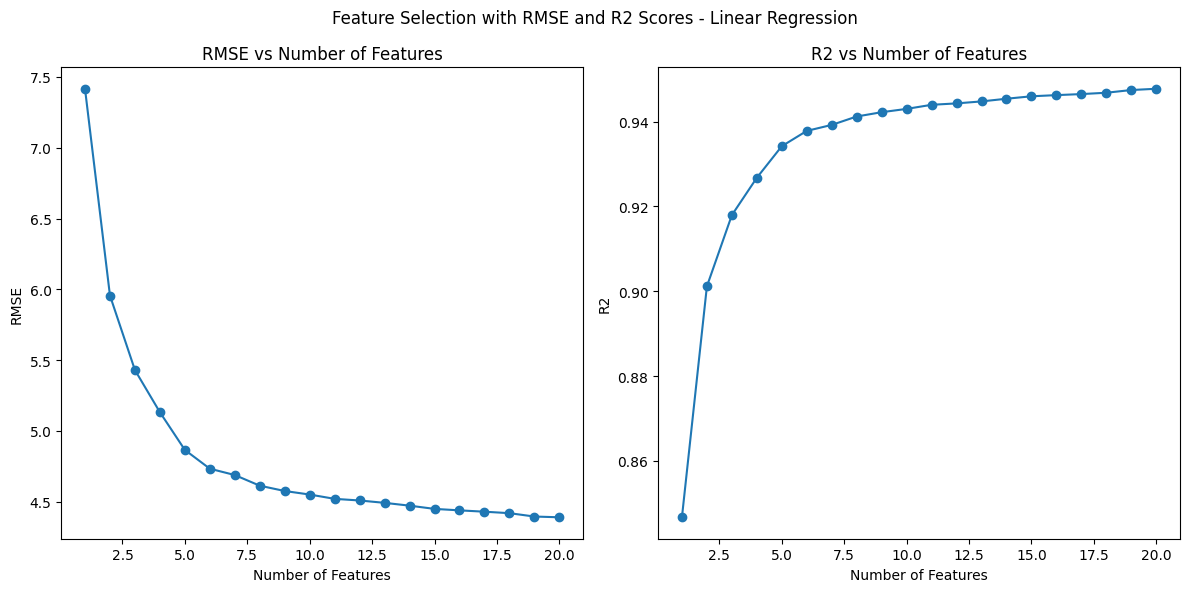

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o')
plt.title('RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(r2_scores) + 1), r2_scores, marker='o')
plt.title('R2 vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R2')

plt.suptitle('Feature Selection with RMSE and R2 Scores - Linear Regression')

plt.tight_layout()
plt.show()

In [32]:
final_model = LinearRegression().fit(x_precipitation_train[selected_features], y_precipitation_train)

In [33]:
y_pred = final_model.predict(x_precipitation_test[selected_features])
test_rmse = np.sqrt(mean_squared_error(y_precipitation_test, y_pred))
test_r2 = adjusted_r2(x_precipitation_test[selected_features], y_precipitation_test, y_pred)
feature_importances = final_model.coef_

In [34]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")
results["Feature Selected by SAL Rank"] = [test_rmse, test_r2, len(feature_importances)]

for feature, importance in zip(selected_features, feature_importances):
    print(f"{feature=}: {importance=:.4f}, SAL rank: {model_SAL_ranks[feature]}")

Test RMSE: 4.3133
Test R2: 0.9489
feature='NorESM2-MM': importance=1.3302, SAL rank: 0.74938
feature='GFDL-ESM4': importance=0.6430, SAL rank: 1.690845
feature='NESM3': importance=-0.4991, SAL rank: 1.696728
feature='CMCC-CM2-HR4': importance=-0.2067, SAL rank: 1.532219
feature='CNRM-CM6-1-HR': importance=0.0779, SAL rank: 1.878019
feature='SAM0-UNICON': importance=-0.0613, SAL rank: 1.260866
feature='MIROC6': importance=0.2437, SAL rank: 1.21491
feature='MRI-ESM2-0': importance=-0.0603, SAL rank: 1.86375
feature='GISS-E2-1-H': importance=-0.0300, SAL rank: 1.936683
feature='MPI-ESM1-2-HR': importance=0.1530, SAL rank: 1.604126
feature='HadGEM3-GC31-LL': importance=-0.2539, SAL rank: 1.5375
feature='CAMS-CSM1-0': importance=-0.0773, SAL rank: 1.791793
feature='MCM-UA-1-0': importance=-0.3046, SAL rank: 1.875888
feature='IITM-ESM': importance=0.1294, SAL rank: 1.715063
feature='IPSL-CM6A-LR': importance=0.0891, SAL rank: 1.320407
feature='E3SM-1-0': importance=-0.2343, SAL rank: 1.30258

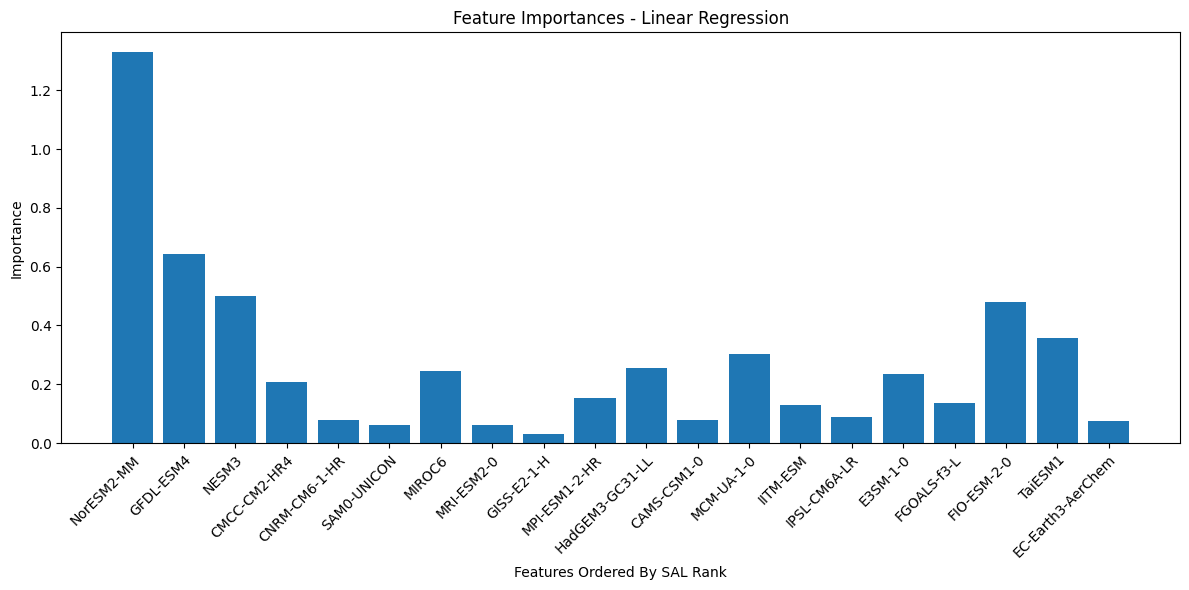

In [56]:
plt.figure(figsize=(12, 6))
plt.bar(selected_features, np.abs(feature_importances))
plt.title('Feature Importances - Linear Regression')
plt.xlabel('Features Ordered By SAL Rank')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor' )
plt.tight_layout()
plt.show()

Lets look if there is some connection between rank and the importance of the feature.

In [36]:
import seaborn as sns

In [37]:
correlation_1 = np.corrcoef([model_SAL_ranks[feature] for feature in selected_features], np.abs(feature_importances))[0, 1]

In [38]:
np.abs(feature_importances)

array([1.33016079, 0.64303648, 0.49909757, 0.20667985, 0.07787409,
       0.06126329, 0.24370381, 0.06029166, 0.02999746, 0.15299667,
       0.25389673, 0.07732098, 0.30458073, 0.12935264, 0.08908348,
       0.23433446, 0.1353857 , 0.4787646 , 0.35735764, 0.0741099 ])

In [39]:
models_rank_importance = {feature: [model_SAL_ranks[feature], np.abs(feature_importances[i])] for i, feature in enumerate(selected_features)}

Pearson Correlation: -0.6171963272254098
Spearman Correlation: -0.4947368421052631
Kendall's Tau: -0.37894736842105264
Mutual Information: 0.06637052197477539
Linear Regression - R² Score: 0.38093130634053507
Linear Regression - Slope: -0.6158700652229754
Linear Regression - Intercept: 1.2376199268158905


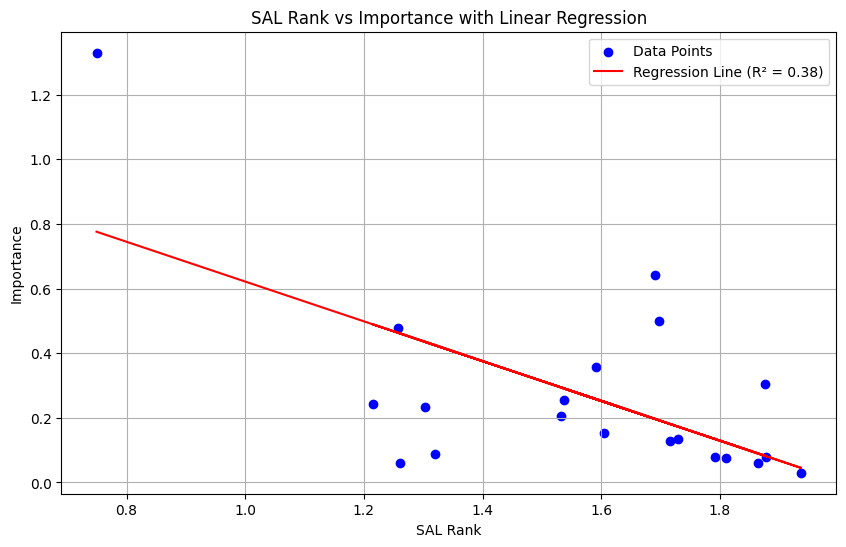

In [41]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import entropy

sal_ranks_df = pd.DataFrame(models_rank_importance.values(), index=models_rank_importance.keys(), columns=['SAL_Rank', 'Importance'])

# Pearson, Spearman, Kendall Correlations
pearson_corr, _ = pearsonr(sal_ranks_df['SAL_Rank'], sal_ranks_df['Importance'])
spearman_corr, _ = spearmanr(sal_ranks_df['SAL_Rank'], sal_ranks_df['Importance'])
kendall_tau, _ = kendalltau(sal_ranks_df['SAL_Rank'], sal_ranks_df['Importance'])
entropy_sal = entropy(sal_ranks_df['SAL_Rank'])
entropy_importance = entropy(sal_ranks_df['Importance'])

mutual_info = mutual_info_regression(sal_ranks_df[['SAL_Rank']], sal_ranks_df['Importance'])[0]
normalized_mi = mutual_info / min(entropy_sal, entropy_importance)

# Linear Regression
X = sal_ranks_df[['SAL_Rank']]
y = sal_ranks_df['Importance']
reg = LinearRegression().fit(X, y)
regression_score = reg.score(X, y)  # R-squared score
regression_slope = reg.coef_[0]     # Slope
regression_intercept = reg.intercept_  # Intercept

# Print results
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall's Tau: {kendall_tau}")
print(f"Mutual Information: {normalized_mi}")
print(f"Linear Regression - R² Score: {regression_score}")
print(f"Linear Regression - Slope: {regression_slope}")
print(f"Linear Regression - Intercept: {regression_intercept}")

# Plot SAL Rank vs Importance with regression line
plt.figure(figsize=(10, 6))
plt.scatter(sal_ranks_df['SAL_Rank'], sal_ranks_df['Importance'], color='b', label='Data Points')
plt.plot(sal_ranks_df['SAL_Rank'], reg.predict(X), color='r', label=f'Regression Line (R² = {regression_score:.2f})')
plt.title('SAL Rank vs Importance with Linear Regression')
plt.xlabel('SAL Rank')
plt.ylabel('Importance')
plt.grid(True)
plt.legend()
plt.show()


In [55]:
y

NorESM2-MM           1.330161
GFDL-ESM4            0.643036
NESM3                0.499098
CMCC-CM2-HR4         0.206680
CNRM-CM6-1-HR        0.077874
SAM0-UNICON          0.061263
MIROC6               0.243704
MRI-ESM2-0           0.060292
GISS-E2-1-H          0.029997
MPI-ESM1-2-HR        0.152997
HadGEM3-GC31-LL      0.253897
CAMS-CSM1-0          0.077321
MCM-UA-1-0           0.304581
IITM-ESM             0.129353
IPSL-CM6A-LR         0.089083
E3SM-1-0             0.234334
FGOALS-f3-L          0.135386
FIO-ESM-2-0          0.478765
TaiESM1              0.357358
EC-Earth3-AerChem    0.074110
Name: Importance, dtype: float64

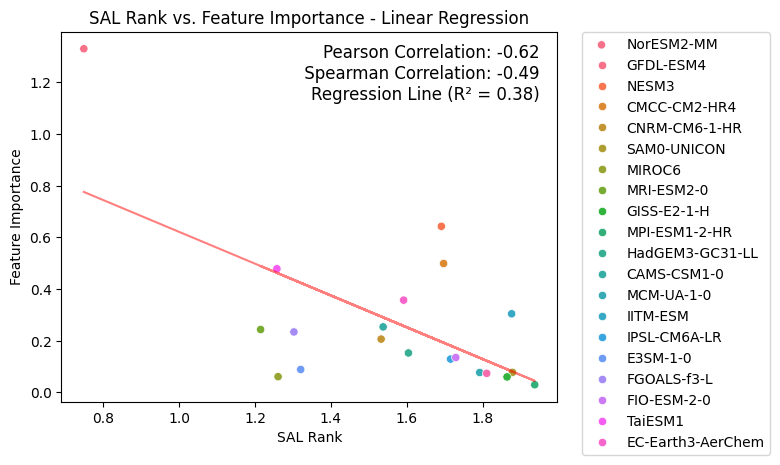

In [57]:
sns.scatterplot(x=[model_SAL_ranks[feature] for feature in selected_features], y=np.abs(feature_importances), hue=selected_features)
plt.text(1.95, 1.35, f'Pearson Correlation: {correlation_1:.2f}\n Spearman Correlation: {spearman_corr:.2f}\nRegression Line (R² = {regression_score:.2f})\n', ha='right', va='top', fontsize=12)
plt.plot(sal_ranks_df['SAL_Rank'], reg.predict(X), color='r', label=f'Regression Line (R² = {regression_score:.2f})', alpha=0.5)
plt.title("SAL Rank vs. Feature Importance - Linear Regression")
plt.xlabel("SAL Rank")
plt.ylabel("Feature Importance")
plt.legend(selected_features, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

R-squared: -0.9118
Mean Squared Error: 0.2682


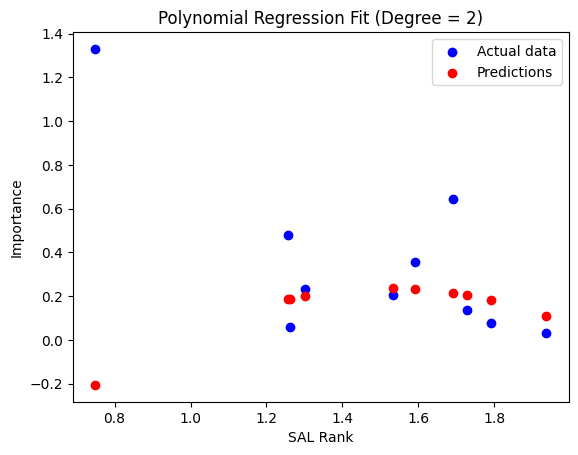

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Apply polynomial transformation
degree = 2  # Change the degree if you want a higher polynomial fit
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred = model.predict(X_test_poly)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print performance metrics
print(f'R-squared: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.scatter(X_test, y_pred, color='red', label='Predictions')
plt.xlabel('SAL Rank')
plt.ylabel('Importance')
plt.title('Polynomial Regression Fit (Degree = 2)')
plt.legend()
plt.show()

#### Feature Selection by SAL Rank

In [59]:
models_subset = []
rmse_scores = {}
r2_scores = {}
feature_importances = {}
for model, rank in model_SAL_ranks.items():
    models_subset.append(model)
    train_subset = x_precipitation_train[models_subset]

    rmse = np.sqrt(-cross_val_score(LinearRegression(), train_subset, y_precipitation_train, 
                                    scoring='neg_mean_squared_error', 
                                    cv=5)).mean()
    
    
    rmse_scores[len(models_subset)] = rmse

    model = LinearRegression().fit(x_precipitation_train[models_subset], y_precipitation_train)
    r2_scores[len(models_subset)] =  adjusted_r2(x_precipitation_test[models_subset], y_precipitation_test, model.predict(x_precipitation_test[models_subset]))

    feature_importances[len(models_subset)] = model.coef_

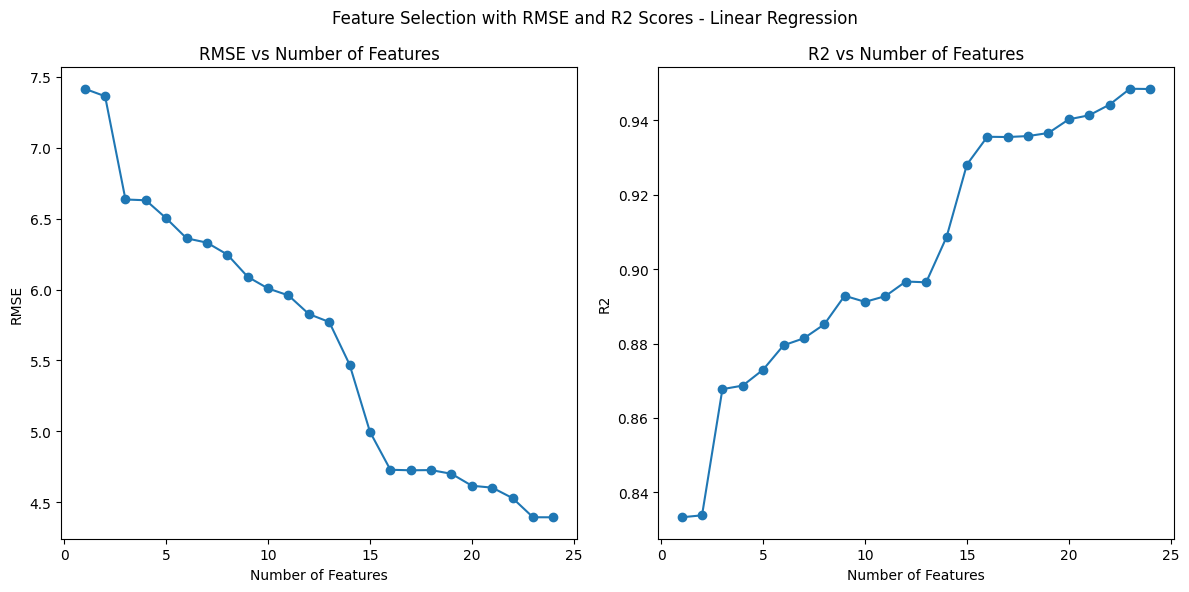

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rmse_scores.keys(), rmse_scores.values(), marker='o')
plt.title('RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(r2_scores.keys(), r2_scores.values(), marker='o')
plt.title('R2 vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R2')

plt.suptitle('Feature Selection with RMSE and R2 Scores - Linear Regression')

plt.tight_layout()
plt.show()

#### Polynomial Regression

In [61]:
polynomial_2nd_degree = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
polynomial_3rd_degree = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])


In [62]:
polynomial_2nd_degree.fit(x_precipitation_train, y_precipitation_train)

y_precipitation_pred_polynomial_2nd_degree = polynomial_2nd_degree.predict(x_precipitation_test)

mock_X = np.zeros((polynomial_2nd_degree.named_steps['linear'].n_features_in_, polynomial_2nd_degree.named_steps['linear'].n_features_in_))
rmse_2nd_degree_precipitation = root_mean_squared_error(y_precipitation_test, y_precipitation_pred_polynomial_2nd_degree)
r2_2nd_degree_precipitation = adjusted_r2(mock_X, y_precipitation_test, y_precipitation_pred_polynomial_2nd_degree)

print(f"2nd Degree Polynomial Regression Model - RMSE: {rmse_2nd_degree_precipitation}, R2: {r2_2nd_degree_precipitation}")

results["2nd Degree Polynomial Regression Model"] = [rmse_2nd_degree_precipitation, r2_2nd_degree_precipitation, polynomial_2nd_degree.named_steps['linear'].n_features_in_]

2nd Degree Polynomial Regression Model - RMSE: 2.705347318789563, R2: 0.9750598449380743


In [63]:
polynomial_3rd_degree.fit(x_precipitation_train, y_precipitation_train)

y_precipitation_pred_polynomial_3rd_degree = polynomial_3rd_degree.predict(x_precipitation_test)

rmse_3rd_degree_precipitation = root_mean_squared_error(y_precipitation_test, y_precipitation_pred_polynomial_3rd_degree)
r2_3rd_degree_precipitation = adjusted_r2(x_precipitation_test, y_precipitation_test, y_precipitation_pred_polynomial_3rd_degree)

print(f"3rd Degree Polynomial Regression Model - RMSE: {rmse_3rd_degree_precipitation}, R2: {r2_3rd_degree_precipitation}")

results["3rd Degree Polynomial Regression Model"] = [rmse_3rd_degree_precipitation, r2_3rd_degree_precipitation, polynomial_3rd_degree.named_steps['linear'].n_features_in_]

3rd Degree Polynomial Regression Model - RMSE: 111.73478992213452, R2: -33.355520069056034


In [64]:
selected_features_2nd, rmse_scores_2nd, r2_scores_2nd = feature_selection(x_precipitation_train, y_precipitation_train, Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))]), min_improvement=0.0005)

/tmp/ipykernel_1336/2749587587.py:31: RuntimeWarning: invalid value encountered in scalar divide
  if (previous_best_rmse - best_rmse) / previous_best_rmse < min_improvement:


Added feature: NorESM2-MM with SAL rank 0.74938, RMSE: 6.9753, R2: 0.8655
Added feature: GFDL-ESM4 with SAL rank 1.690845, RMSE: 5.6924, R2: 0.9104
Added feature: NESM3 with SAL rank 1.696728, RMSE: 4.9251, R2: 0.9331
Added feature: UKESM1-0-LL with SAL rank 1.540298, RMSE: 4.4950, R2: 0.9449
Added feature: MRI-ESM2-0 with SAL rank 1.86375, RMSE: 4.3316, R2: 0.9490
Added feature: HadGEM3-GC31-LL with SAL rank 1.5375, RMSE: 4.1463, R2: 0.9535
Added feature: CNRM-CM6-1-HR with SAL rank 1.878019, RMSE: 4.0187, R2: 0.9566
Added feature: FGOALS-f3-L with SAL rank 1.728859, RMSE: 3.8871, R2: 0.9597
Added feature: MCM-UA-1-0 with SAL rank 1.875888, RMSE: 3.8066, R2: 0.9620
Added feature: IITM-ESM with SAL rank 1.715063, RMSE: 3.7239, R2: 0.9645
Added feature: CAMS-CSM1-0 with SAL rank 1.791793, RMSE: 3.6231, R2: 0.9667
Added feature: TaiESM1 with SAL rank 1.59149, RMSE: 3.5438, R2: 0.9694
Added feature: FIO-ESM-2-0 with SAL rank 1.257748, RMSE: 3.4349, R2: 0.9717
Added feature: GISS-E2-1-H wi

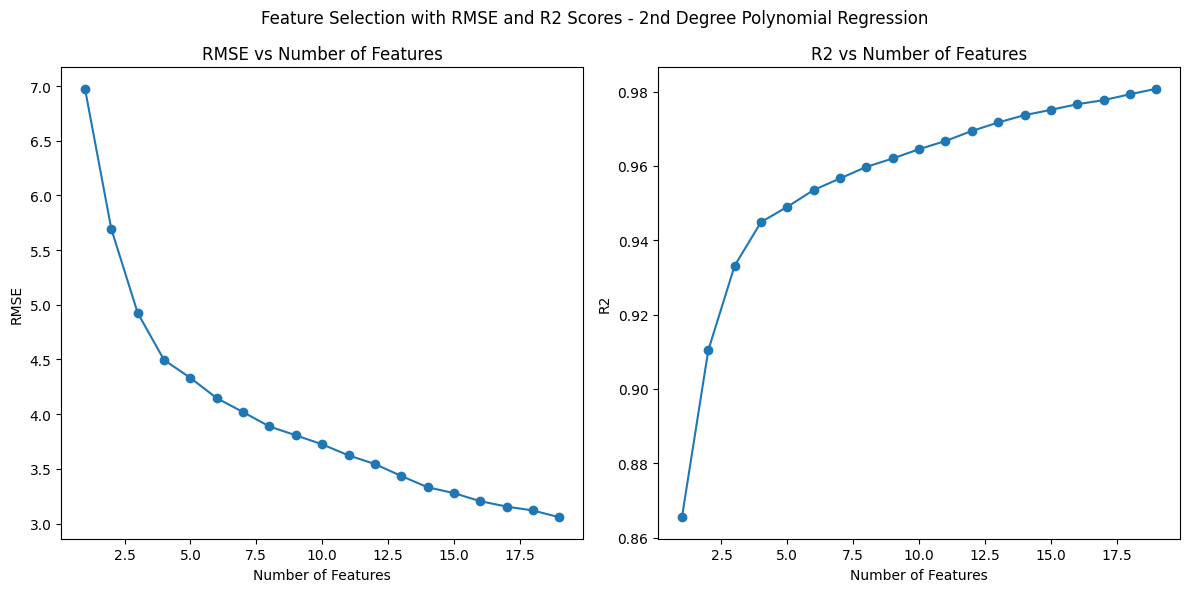

In [65]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(rmse_scores_2nd) + 1), rmse_scores_2nd, marker='o')
plt.title('RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(r2_scores_2nd) + 1), r2_scores_2nd, marker='o')
plt.title('R2 vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R2')

plt.suptitle('Feature Selection with RMSE and R2 Scores - 2nd Degree Polynomial Regression')


plt.tight_layout()
plt.show()

In [66]:
final_model_2nd = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))]).fit(x_precipitation_train[selected_features_2nd], y_precipitation_train)

In [67]:
y_pred = final_model_2nd.predict(x_precipitation_test[selected_features_2nd])
test_rmse = np.sqrt(mean_squared_error(y_precipitation_test, y_pred))
mock_X = np.zeros((final_model_2nd.named_steps['linear'].n_features_in_, final_model_2nd.named_steps['linear'].n_features_in_))
test_r2 = adjusted_r2(mock_X, y_precipitation_test, y_pred)

In [68]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")
results["Feature Selected by SAL Rank - 2nd Degree"] = [test_rmse, test_r2, final_model_2nd.named_steps['linear'].n_features_in_]


Test RMSE: 3.1381
Test R2: 0.9692


In [69]:
feature_importances_2 = final_model_2nd.named_steps['linear'].coef_

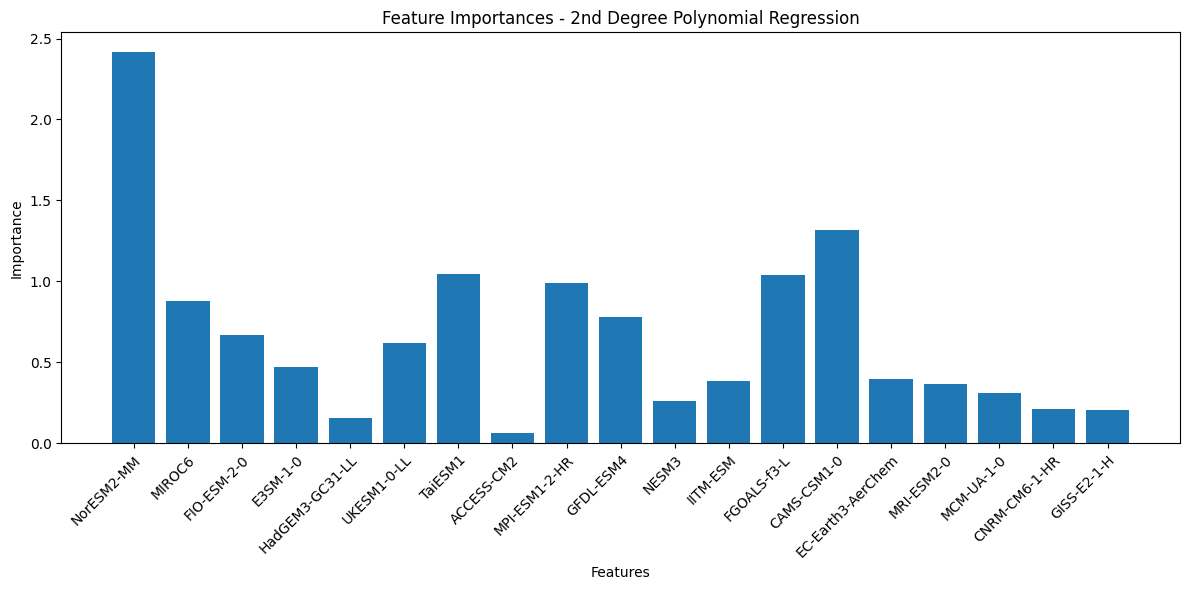

In [70]:
plt.figure(figsize=(12, 6))
plt.bar(sorted(selected_features_2nd, key=model_SAL_ranks.get), np.abs(feature_importances_2[:19]))
plt.title('Feature Importances - 2nd Degree Polynomial Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor' )
plt.tight_layout()
plt.show()

In [71]:
correlation_2 = np.corrcoef([model_SAL_ranks[feature] for feature in selected_features_2nd], [np.abs(final_model_2nd.named_steps['linear'].coef_[i]) for i, feature in enumerate(selected_features_2nd)])[0, 1]

Pearson Correlation: -0.4071480272183538
Spearman Correlation: 0.06666666666666667
Kendall's Tau: 0.06432748538011696
Mutual Information: 0.0785178072440161
Linear Regression - R² Score: 0.16576951606779733
Linear Regression - Slope: -0.7706946202152832
Linear Regression - Intercept: 1.8941000454391277


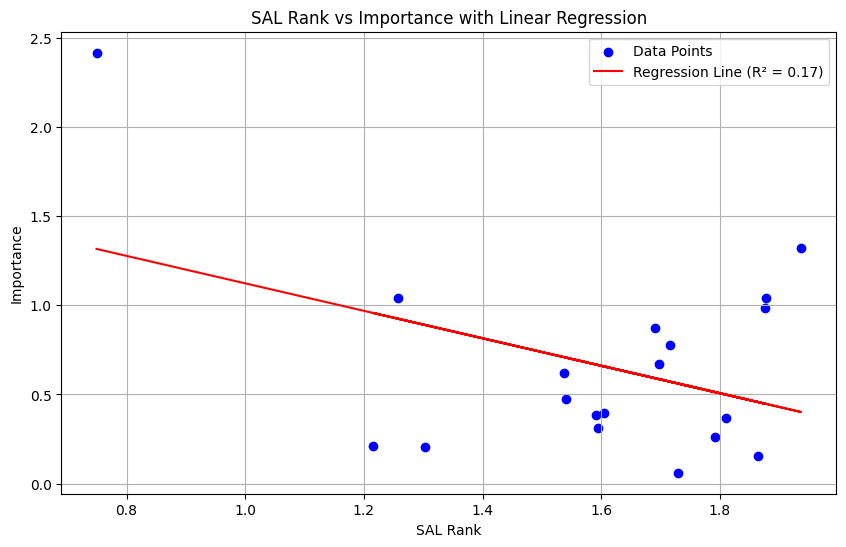

In [73]:
models_rank_importance_poly = {feature: [model_SAL_ranks[feature], np.abs(feature_importances_2[i])] for i, feature in enumerate(selected_features_2nd)}
sal_ranks_df_poly = pd.DataFrame(models_rank_importance_poly.values(), index=models_rank_importance_poly.keys(), columns=['SAL_Rank', 'Importance'])

# Pearson, Spearman, Kendall Correlations
pearson_corr, _ = pearsonr(sal_ranks_df_poly['SAL_Rank'], sal_ranks_df_poly['Importance'])
spearman_corr, _ = spearmanr(sal_ranks_df_poly['SAL_Rank'], sal_ranks_df_poly['Importance'])
kendall_tau, _ = kendalltau(sal_ranks_df_poly['SAL_Rank'], sal_ranks_df_poly['Importance'])
entropy_sal = entropy(sal_ranks_df_poly['SAL_Rank'])
entropy_importance = entropy(sal_ranks_df_poly['Importance'])

mutual_info = mutual_info_regression(sal_ranks_df_poly[['SAL_Rank']], sal_ranks_df_poly['Importance'])[0]
normalized_mi = mutual_info / min(entropy_sal, entropy_importance)

# Linear Regression
X = sal_ranks_df_poly[['SAL_Rank']]
y = sal_ranks_df_poly['Importance']
reg = LinearRegression().fit(X, y)
regression_score = reg.score(X, y)  # R-squared score
regression_slope = reg.coef_[0]     # Slope
regression_intercept = reg.intercept_  # Intercept

# Print results
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall's Tau: {kendall_tau}")
print(f"Mutual Information: {normalized_mi}")
print(f"Linear Regression - R² Score: {regression_score}")
print(f"Linear Regression - Slope: {regression_slope}")
print(f"Linear Regression - Intercept: {regression_intercept}")

# Plot SAL Rank vs Importance with regression line
plt.figure(figsize=(10, 6))
plt.scatter(sal_ranks_df_poly['SAL_Rank'], sal_ranks_df_poly['Importance'], color='b', label='Data Points')
plt.plot(sal_ranks_df_poly['SAL_Rank'], reg.predict(X), color='r', label=f'Regression Line (R² = {regression_score:.2f})')
plt.title('SAL Rank vs Importance with Linear Regression')
plt.xlabel('SAL Rank')
plt.ylabel('Importance')
plt.grid(True)
plt.legend()
plt.show()

R-squared: 0.8667
Mean Squared Error: 0.0843


/root/.pyenv/versions/3.10.11/envs/dsproj/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


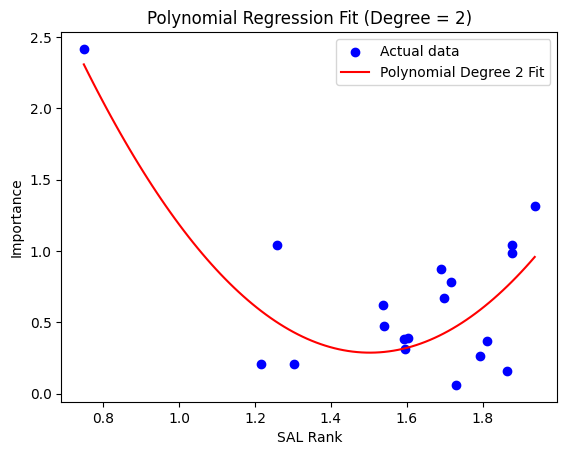

In [74]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply polynomial transformation
degree = 2  # Change the degree if you want a higher polynomial fit
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred = model.predict(X_test_poly)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print performance metrics
print(f'R-squared: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

# Create a smooth curve for the polynomial fit
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Generate 100 points between min and max of X
X_range_poly = poly.transform(X_range)  # Transform the range to polynomial features
y_range_pred = model.predict(X_range_poly)  # Predict on the smooth range

# Plot the actual data and the predicted function
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X_range, y_range_pred, color='red', label=f'Polynomial Degree {degree} Fit')
plt.xlabel('SAL Rank')
plt.ylabel('Importance')
plt.title(f'Polynomial Regression Fit (Degree = {degree})')
plt.legend()
plt.show()

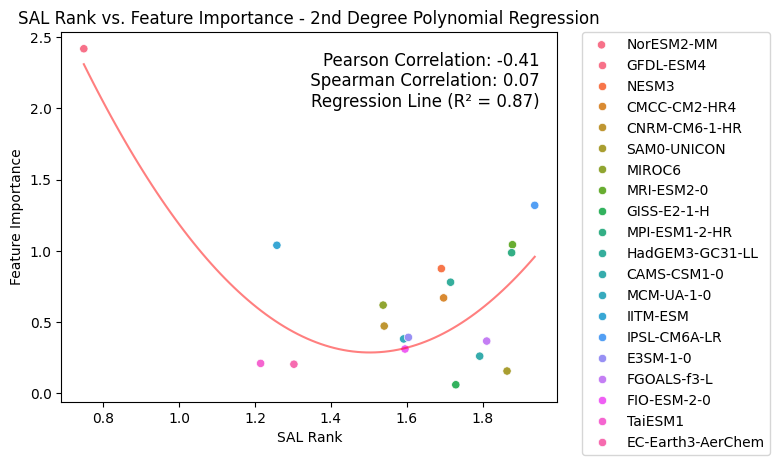

In [75]:
sns.scatterplot(x=[model_SAL_ranks[feature] for feature in selected_features_2nd], y=[np.abs(final_model_2nd.named_steps['linear'].coef_[i]) for i, feature in enumerate(selected_features_2nd)], hue=selected_features_2nd)
plt.text(1.95, 2.4, f'Pearson Correlation: {correlation_2:.2f}\n Spearman Correlation: {spearman_corr:.2f}\nRegression Line (R² = {r2:.2f})', ha='right', va='top', fontsize=12)
plt.plot(X_range, y_range_pred, color='red', label=f'Polynomial Degree {degree} Fit', alpha=0.5)
plt.title("SAL Rank vs. Feature Importance - 2nd Degree Polynomial Regression")
plt.xlabel("SAL Rank")
plt.ylabel("Feature Importance")
plt.legend(selected_features, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [76]:
def make_pretty(styler):
    styler.set_caption("Ensembling Models Performance")
    styler.background_gradient(subset=['RMSE'], vmin=0, vmax=10, cmap='coolwarm')
    styler.background_gradient(subset=['Adjusted R2'], vmin=0, vmax=1, cmap='coolwarm_r')
    return styler

,RMSE,Adjusted R2,Number of Features
Baseline - Mean of Y Train,19.215735,-0.000737,1
Baseline - Mean of X,8.111158,0.818955,24
Weighted Average by SAL Rank,7.961140,0.825590,24
Linear Regression Model,4.330999,0.948383,24
Linear Regression Feature Selected by SAL Rank,4.313309,0.948934,20
2nd Degree Polynomial Regression Model,2.705347,0.975060,325
3rd Degree Polynomial Regression Model,111.734790,-33.355520,2925
2nd Degree Polynomial Regression Feature Selected by SAL Rank,3.138091,0.969243,210


In [88]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE', 'Adjusted R2', "Number of Features"])
results_df.rename(index={'Feature Selected by SAL Rank': 'Linear Regression Feature Selected by SAL Rank', 
                        'Feature Selected by SAL Rank - 2nd Degree': '2nd Degree Polynomial Regression Feature Selected by SAL Rank'}, inplace=True)
results_df.style.pipe(make_pretty)

,RMSE,Adjusted R2,Number of Features
Baseline - Mean of Y Train,19.215735,-0.000737,1
Baseline - Mean of X,8.111158,0.818955,24
Weighted Average by SAL Rank,7.961140,0.825590,24
Linear Regression Model,4.330999,0.948383,24
Linear Regression Feature Selected by SAL Rank,4.313309,0.948934,20
2nd Degree Polynomial Regression Model,2.705347,0.975060,325
3rd Degree Polynomial Regression Model,111.734790,-33.355520,2925
2nd Degree Polynomial Regression Feature Selected by SAL Rank,3.138091,0.969243,210


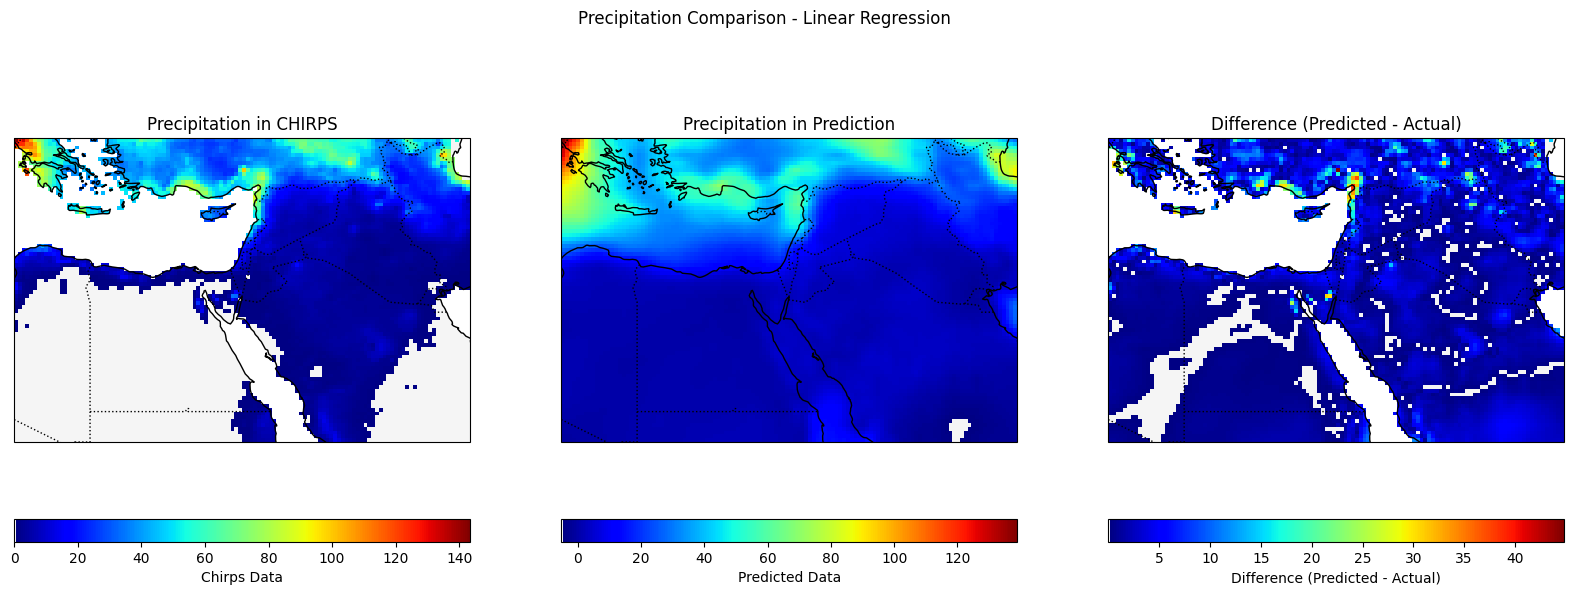

In [80]:
reg_vis = final_model.predict(X_precip[selected_features])
visualize_results(y_precip.reshape(80, 120), reg_vis.reshape(80, 120), "Precipitation Comparison - Linear Regression")

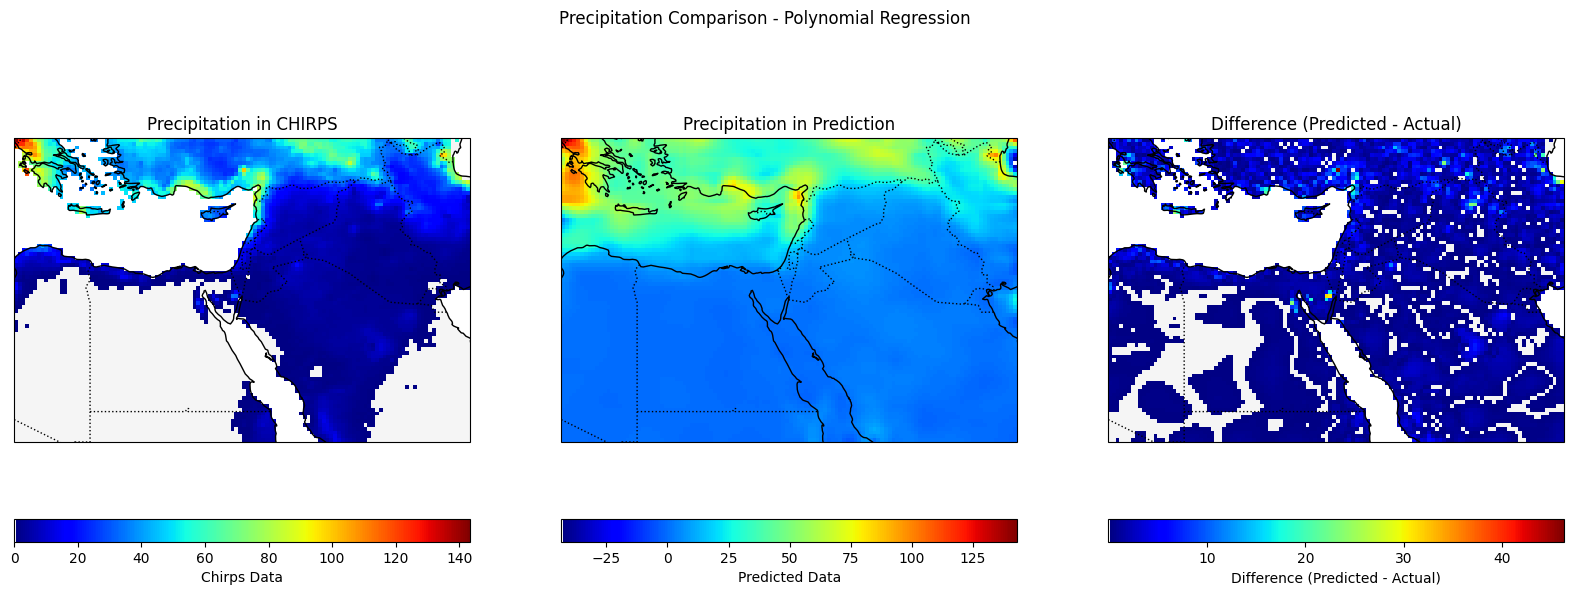

In [81]:
poly_vis = final_model_2nd.predict(X_precip[selected_features_2nd])
visualize_results(y_precip.reshape(80, 120), poly_vis.reshape(80, 120), "Precipitation Comparison - Polynomial Regression")

In [ ]:
ori

# Trainig U-Net

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
class PrecipitationDataset(Dataset):
    def __init__(self, climate_models, real_world_data):
        self.climate_models = climate_models  # Dictionary of model data
        self.real_world_data = torch.tensor(real_world_data, dtype=torch.float32)
        self.model_names = list(climate_models.keys())

    def __len__(self):
        return len(self.real_world_data)

    def __getitem__(self, idx):
        # Stack all climate models for the given year
        climate_data = torch.stack([torch.tensor(self.climate_models[model][idx], dtype=torch.float32) 
                                    for model in self.model_names])
        return climate_data, self.real_world_data[idx]


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.up_conv1(x)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up_conv2(x)
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv3(x)
        x = self.outc(x)
        return x

In [ ]:
def masked_loss(pred, target):
#     print(f"{pred.shape=}, {target.shape=}, {mask.shape=}")
    masked_pred = pred[mask]
    masked_target = target[mask]
    return nn.functional.mse_loss(masked_pred, masked_target)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)
    
    # Reshape if necessary
    predictions = predictions.reshape(-1)
    targets = targets.reshape(-1)
    
    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    correlation, _ = pearsonr(targets, predictions)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Correlation': correlation
    }

In [ ]:
def predict(model, climate_data, device):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(climate_data, dtype=torch.float32).unsqueeze(0).to(device)
        outputs = model(inputs)
    return outputs.squeeze().cpu().numpy()


In [79]:
def visualize_results(actual, predicted, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20),subplot_kw={'projection': ccrs.PlateCarree()})
    vis_helper.plot_precp_heatmap(ax1, actual, boundaries_middle_east, "Chirps Data", "Precipitation in CHIRPS", 0) 
    vis_helper.plot_precp_heatmap(ax2, predicted, boundaries_middle_east, "Predicted Data", "Precipitation in Prediction", 0) 
    vis_helper.plot_precp_heatmap(ax3, np.abs(predicted - actual), boundaries_middle_east, "Difference (Predicted - Actual)", "Difference (Predicted - Actual)", 0) 
    plt.suptitle(title, y=0.4)
#     plt.tight_layout()
    plt.show()


In [ ]:
generator1 = torch.Generator().manual_seed(9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
mask = chirps_precip_data.mask

In [ ]:
dataset = PrecipitationDataset(masked_precip, chirps_precip_data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator1)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
model = UNet(n_channels=24, n_classes=1)
train_model(model, train_loader, test_loader, num_epochs=30, learning_rate=0.001)

In [ ]:
metrics = evaluate_model(model, test_loader, device)
print("Model Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
sample_climate_data = np.stack([model_data[-1] for model_data in masked_precip.values()])
predicted_precip = predict(model, sample_climate_data, device)

actual_precip = chirps_precip_data[-1]
visualize_results(actual_precip, predicted_precip, "Precipitation Comparison")

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(actual_precip.flatten(), predicted_precip.flatten(), alpha=0.5)
plt.plot([0, np.max(actual_precip)], [0, np.max(actual_precip)], 'r--')
plt.xlabel("Actual Precipitation")
plt.ylabel("Predicted Precipitation")
plt.title("Actual vs Predicted Precipitation")
plt.tight_layout()
plt.show()


# coefficient evaluetion

In [ ]:
def plot_coefficients(coefficients: np.ndarray, model_names: List[str], title: str):
    """
    Plot the coefficients of the regression model.

    Parameters:
    -----------
    coefficients : np.ndarray
        The regression coefficients for each model.
        
    model_names : List[str]
        The names or labels of the models corresponding to the coefficients.

    title : str
        Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, coefficients, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(title)
    plt.show()

In [ ]:
model_names = x_precipitation_train.columns
precipitation_coefficients = naive_lr_model_precipitation.coef_
plot_coefficients(precipitation_coefficients, model_names, 'Precipitation Model Coefficients')



In [ ]:
naive_lr_model_precipitation.coef_